In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [12]:
def sample_data(txt_file, bits, tstart, spice_tstep, samp_tstep, plot=False):
    df = pd.read_csv(txt_file,sep=r'\s+')
    raw_transmittance = df['t'].values
    raw_tnom = (raw_transmittance - np.min(raw_transmittance)) / (np.max(raw_transmittance)-np.min(raw_transmittance))
    raw_time = df['time'].values

    num_sample = 2**bits

    idx_step = int(samp_tstep // spice_tstep)
    idx_start = int(np.argmin(np.abs(raw_time-tstart)))
    idx_stop = int(idx_start + idx_step * num_sample)

    samp_time = raw_time[idx_start:idx_stop:idx_step]
    samp_trans = raw_tnom[idx_start:idx_stop:idx_step]

    if plot:
        plt.plot(samp_time*1e3, samp_trans)
        plt.title('Transmittance Plot')
        plt.xlabel('Time (ms)')
        plt.ylabel('Normalized Transmittance')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return samp_time, samp_trans

def process_fft(time, time_domain_amplitude, plot=False):
    N = len(time)
    #Freq
    tstep = np.mean(np.diff(time))
    fs = 1/tstep
    fft_freq = np.fft.fftfreq(N, d=tstep)
    fft_freq_osd = fft_freq[:N//2]
    #Magintude
    fft_mag = np.abs(np.fft.fft(time_domain_amplitude))
    #Amplitude
    fft_amplitude = fft_mag/N
    fft_amplitude_osd = get_onesided(fft_amplitude)
    #Power Spectrum
    fft_power = fft_mag**2/(N**2)
    fft_power_osd = np.log10(get_onesided(fft_power))*10 #converting it to db
    #Power Spectral Density
    fft_psd = fft_mag**2/(N*fs)
    fft_psd_osd = np.log10(get_onesided(fft_psd))*10
    buffer = [fft_freq_osd, fft_amplitude_osd, fft_power_osd, fft_psd_osd]
    if plot:
        title = ['Amplitude', 'Power Spectrum', 'Power Spectral Density']
        ylabel = ['','dB','dB/Hz']
        plt.figure(figsize=(10, 10))
        for i, item in enumerate(buffer[1:4]):
            plt.subplot(3, 1, i+1)
            plt.plot(fft_freq_osd, item)
            plt.title(title[i])
            plt.xlabel('Frequency [Hz]')
            plt.ylabel(f'{title[i]} {ylabel[i]}')
        plt.tight_layout()
        plt.show()
    return fft_freq_osd, fft_amplitude_osd, fft_power_osd, fft_psd_osd

def get_onesided(vector):
    N = len(vector)
    plus = 1 if N%2 != 0 else 0
    buffer = vector[:N//2+plus] * 2
    buffer[0] /= 2
    return buffer

def find_dynamic_properties(start_freq, freq, power_spectrum):
    N = len(freq)
    idx_sweep_start = int(np.argmin(np.abs(freq - start_freq)))
    idx, fundamental_spur = find_the_next_largest(idx_sweep_start, power_spectrum[idx_sweep_start:N-1])
    #idx_fundamental_freq = np.where(power_spectrum == fundamental_spur)[0][0]
    fundamental_freq = freq[idx]

    print(f'Fundamental Freq: {fundamental_freq}')

    idx2, second_spur = find_the_next_largest(idx ,power_spectrum[idx:N-1])
    second_freq = freq[idx2]
    print(f'second Spur: {second_spur}')
    print(f'second Freq: {second_freq}')
    print(f'idx2: {idx2}')
    
    SFDR = fundamental_spur-second_spur
    print(f'SFDR: {SFDR}')

def find_the_next_largest(idx_start, vector):
    difference = np.diff(vector)
    for i in range(len(difference)-1):
        if difference[i] > 1 and difference[i+1] < 0:
            return i+idx_start+1, vector[i+1]

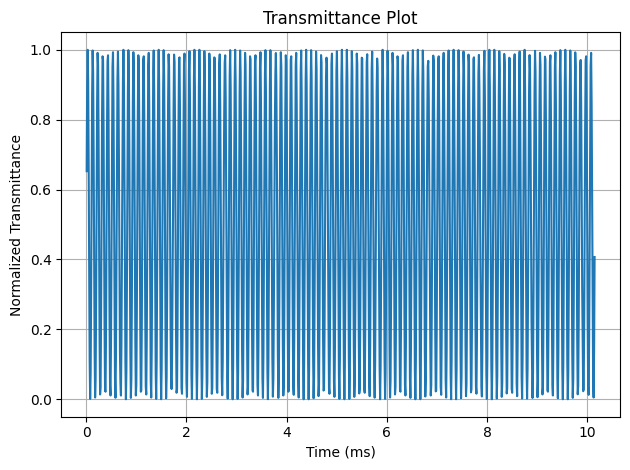

In [ ]:
file = 'top_large/spectral_tb.txt'
time , transmittance = sample_data(file,10,12e-6,1e-9,10e-6,True)

In [19]:
new_data =np.column_stack((time, transmittance))
np.savetxt("top_large/sampled_spectral-tb.txt", new_data, header="Time Transmittance", comments='')

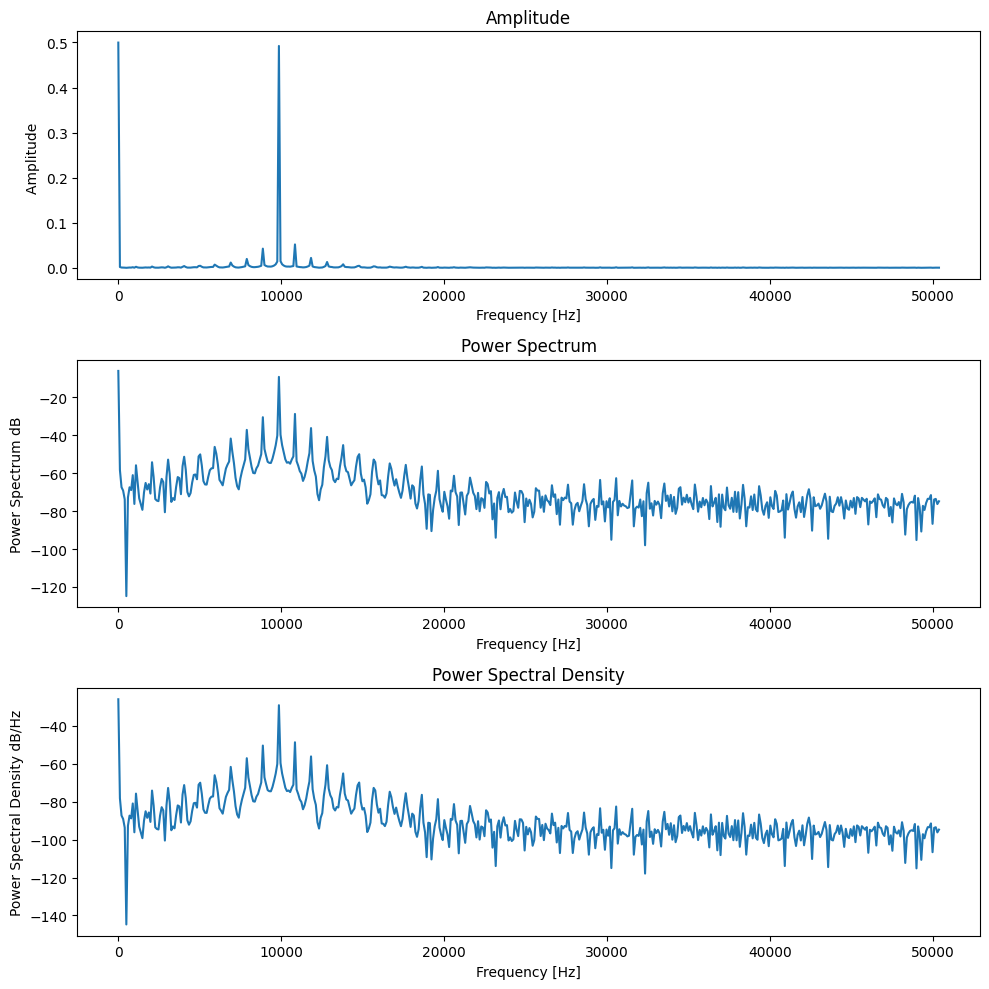

Fundamental Freq: 9860.884226163304
second Spur: -28.714468079004387
second Freq: 10846.972648779632
idx2: 110
SFDR: 19.548985519612756


In [ ]:
fft_freq, fft_amplitude, fft_power, fft_psd =  process_fft(time,transmittance,True)
SFDR = find_dynamic_properties(9e3,fft_freq,fft_power)

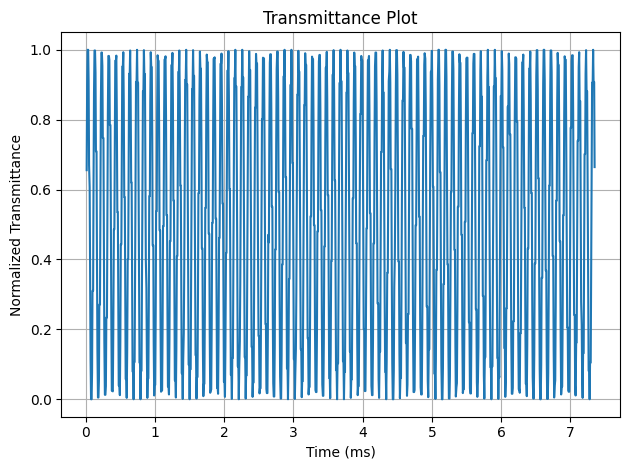

In [8]:
file = 'top_large/signal_test.txt'
time , transmittance = sample_data(file,10,12e-6,100e-9,10e-6,True)

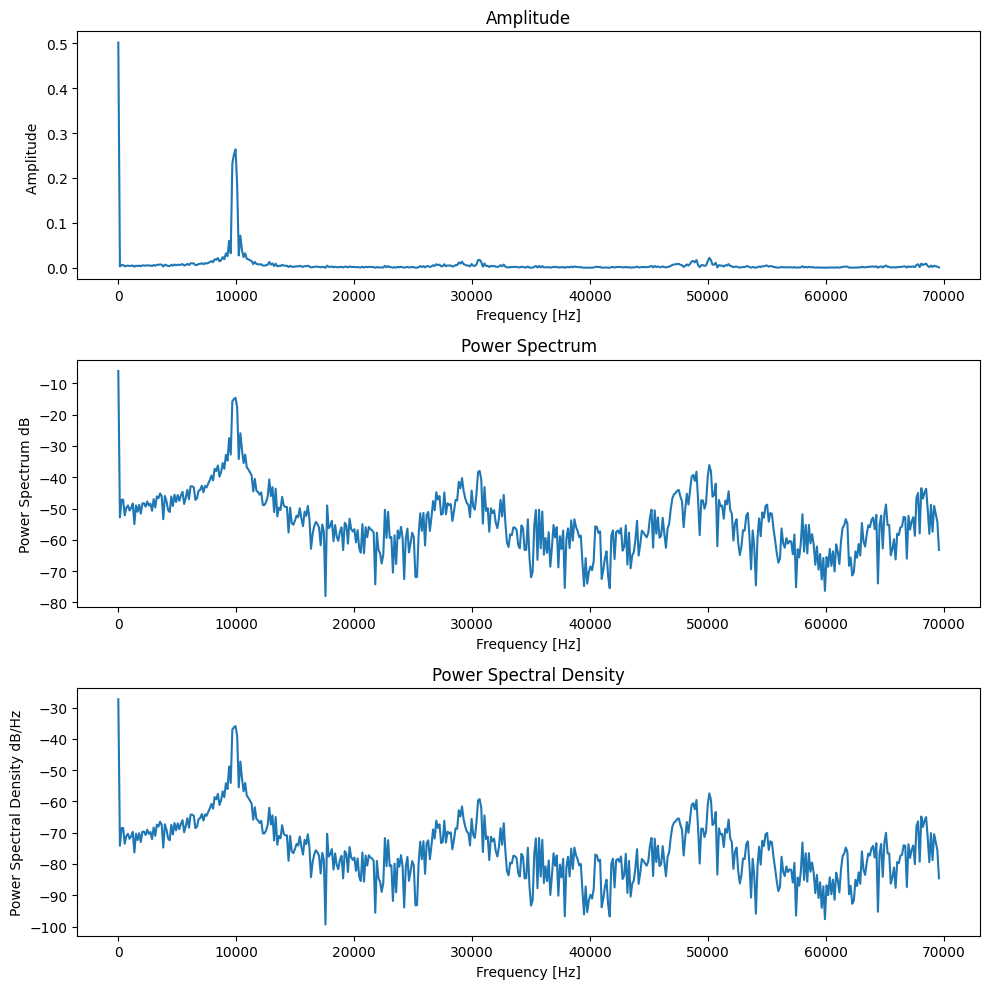

Fundamental Freq: 9120.02102550652
second Spur: -27.474035701381425
second Freq: 9392.260459103729
idx2: 69
SFDR: -5.3408745354078135


In [9]:

fft_freq, fft_amplitude, fft_power, fft_psd =  process_fft(time,transmittance,True)
SFDR = find_dynamic_properties(9e3,fft_freq,fft_power)

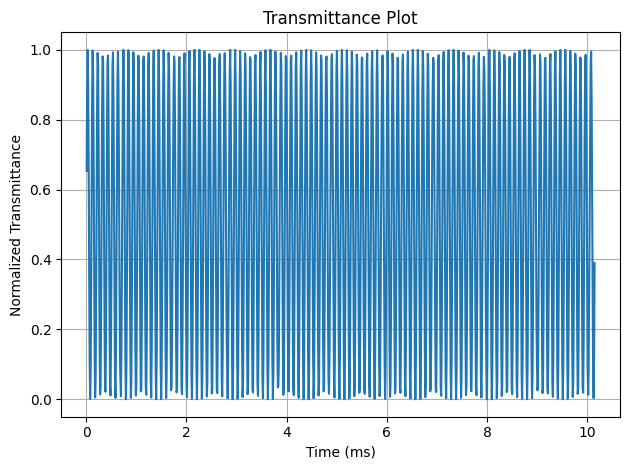

In [14]:
file = 'top_large/spectral_tt_t50_tb.txt'
time , transmittance = sample_data(file,10,12e-6,1e-9,10e-6,True)

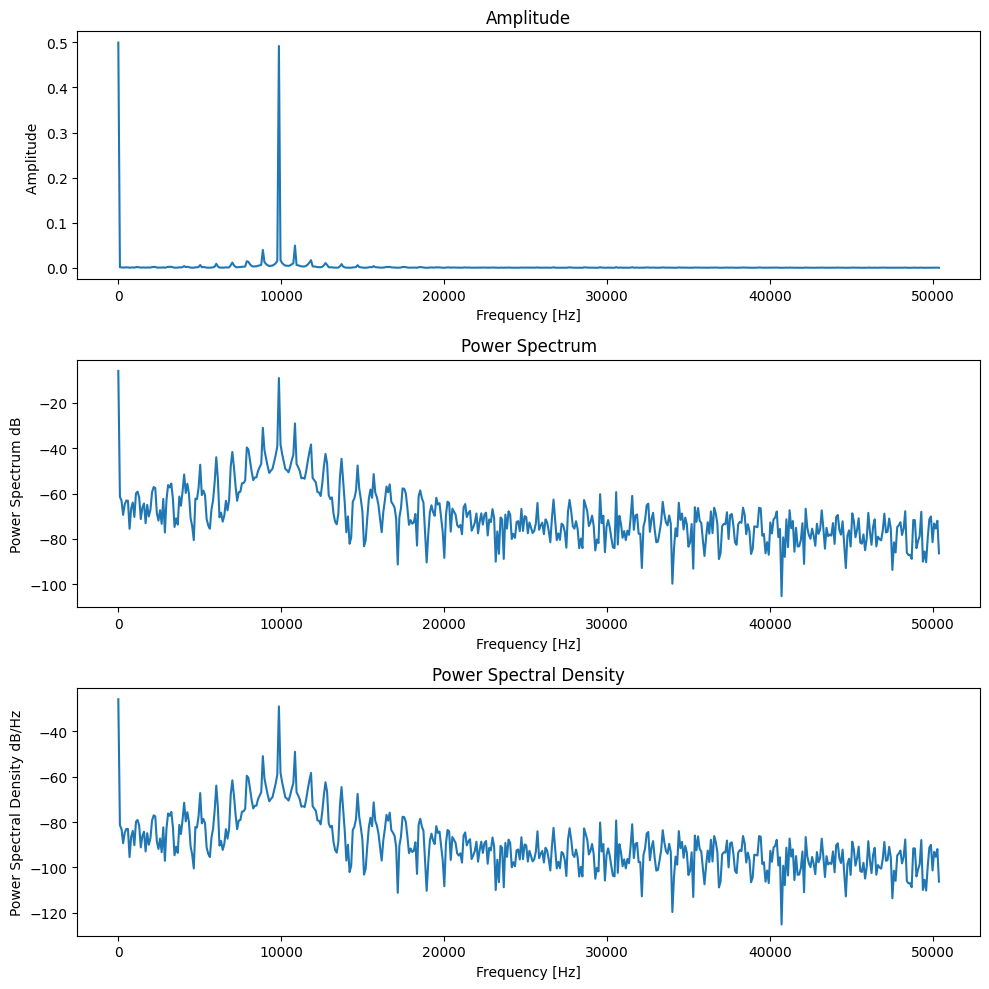

Fundamental Freq: 9859.585987044275
second Spur: -29.15984077645902
second Freq: 10845.544585748703
idx2: 110
SFDR: 19.988292272011932


In [15]:
fft_freq, fft_amplitude, fft_power, fft_psd =  process_fft(time,transmittance,True)
SFDR = find_dynamic_properties(9e3,fft_freq,fft_power)

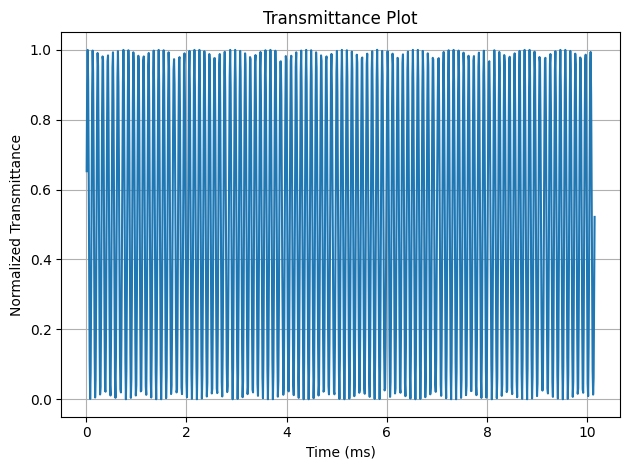

In [20]:
file = 'top_large/spectral_tt_t100_tb.txt'
time , transmittance = sample_data(file,10,12e-6,1e-9,10e-6,True)


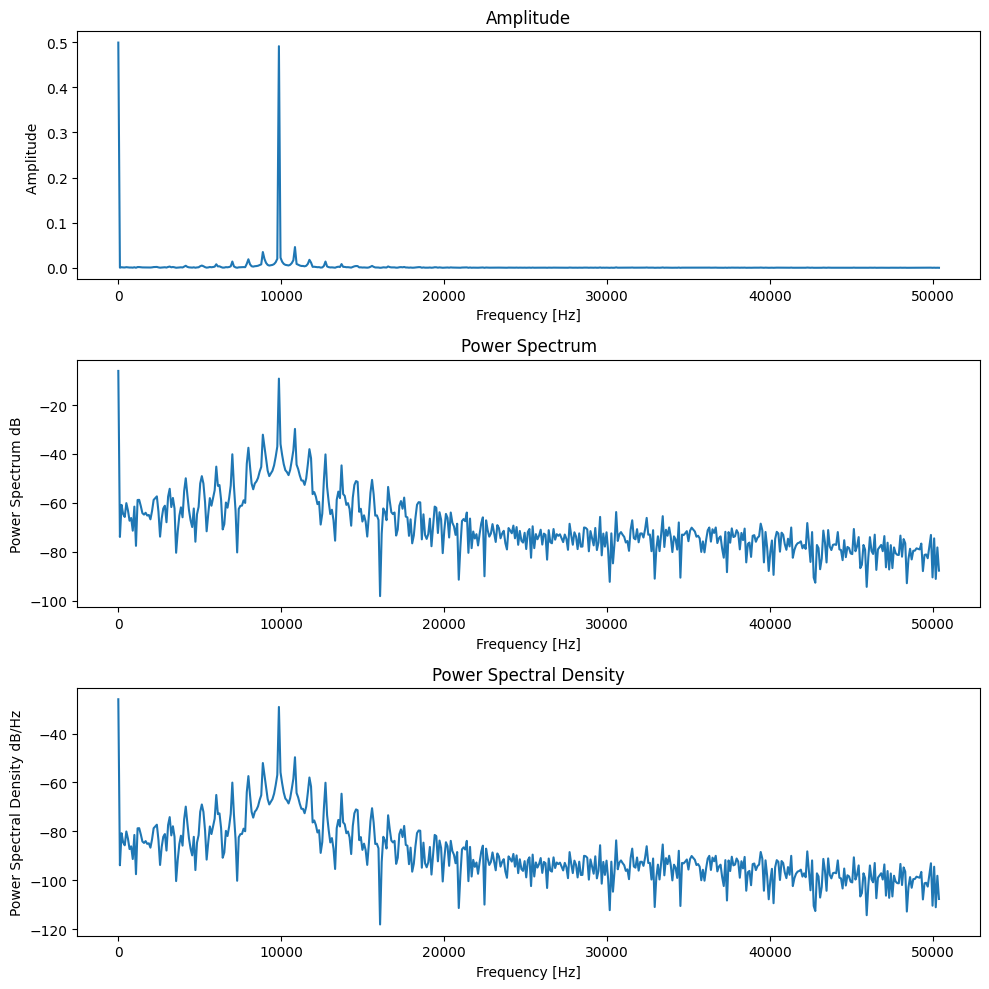

Fundamental Freq: 9858.747471275798
second Spur: -29.76795624807661
second Freq: 10844.622218403378
idx2: 110
SFDR: 20.576355995895227


In [21]:
fft_freq, fft_amplitude, fft_power, fft_psd =  process_fft(time,transmittance,True)
SFDR = find_dynamic_properties(9e3,fft_freq,fft_power)